In [2]:
import matplotlib.pyplot as plt
from datasets.PupilCoreDatasetIfOpened import PupilCoreDatasetIfOpened
from datasets.PupilCoreDatasetPupil import PupilCoreDatasetPupil
import torch
import time
import copy
from torchvision.models.segmentation import FCN_ResNet50_Weights, fcn_resnet50
import numpy as np
import cv2
import utils
from models.trainers import PupilSegmentationTrainer

In [3]:
model = fcn_resnet50(weights=None, num_classes=1)
model

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
DATASET_LEN_TO_USE = 5000
dataset_pupil = PupilCoreDatasetPupil(
    "datasets/PupilCoreDataset/video5_eye0_video.avi",
    'datasets/PupilCoreDataset/video5_eye0_pupildata.csv',
    "datasets/PupilCoreDataset/video5_eye1_video.avi",
    'datasets/PupilCoreDataset/video5_eye1_pupildata.csv',
    DATASET_LEN_TO_USE
)
# dataset_pupil.get_pupil_ellipse()


In [6]:
# dataset_pupil.save_masks("datasets/PupilCoreDataset/created_masks")

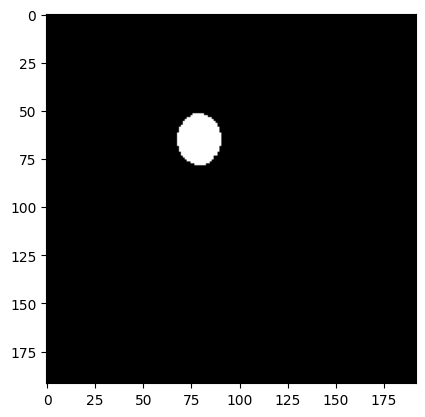

In [7]:
dataset_pupil.load_masks("datasets/PupilCoreDataset/created_masks/eye0", "datasets/PupilCoreDataset/created_masks/eye1")
torch.set_printoptions(edgeitems=100)

plt.imshow(dataset_pupil.eye0_masks[0],cmap='gray')


In [8]:
Pupil_trainer = PupilSegmentationTrainer(model=model, dataset=dataset_pupil, dataset_len=DATASET_LEN_TO_USE)

In [9]:
model.load_state_dict(torch.load("models/weights/resnet50.pt"))

<All keys matched successfully>

In [16]:
def visualize(model, num_images: int = 5):
    model.eval()
    fig = plt.figure()
    model = model.to(device)
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(Pupil_trainer.dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            image = np.transpose(inputs[0].cpu().numpy(), (1, 2, 0)).copy()
            outputs_soft = torch.nn.functional.softmax(outputs['out'][0], dim=1)
            outputs_sig = torch.sigmoid(outputs['out'][0])
            outputs_sig = np.transpose(outputs_sig.cpu().numpy(), (1, 2, 0)).copy()
            

            

            plt.imshow(image)
            plt.show()
            # plt.imshow(outputs_soft)
            # plt.show()
            plt.imshow(outputs_sig)
            plt.show()
            
            #cv2.imshow("xd", image)
            if i >= num_images:
                
                return

In [17]:
visualize(model, 5)

UnboundLocalError: local variable 'outputs_sig' referenced before assignment

<Figure size 640x480 with 0 Axes>

In [12]:
def draw_ellipse():
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(Pupil_trainer.dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)


            image = np.transpose(inputs[0].cpu().numpy(), (1, 2, 0)).copy()
            # outputs_soft = torch.nn.functional.softmax(outputs['out'][0], dim=1)
            outputs_sig = torch.sigmoid(outputs['out'][0])

            outputs_sig = np.transpose(outputs_sig.cpu().numpy(), (1, 2, 0)).copy()

            ellipse = utils.fit_ellipse(outputs_sig)
            utils.draw_ellipse(image, ellipse)

            

            if i >0 :
                break
            


In [13]:
draw_ellipse()

NameError: name 'dataloaders' is not defined